<a href="https://colab.research.google.com/github/standard-aaron/deep-learning-projects/blob/main/pyro_markov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 718 kB 6.7 MB/s 


In [ ]:
import numpy as np
import torch
from torch import nn
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from matplotlib import pyplot as plt

# Overview

In this notebook I'm working through a basic example of a inferring the latent state of a Gaussian HMM via SVI + amortized inference.

$Z$ is the latent state; $Z_{t+1} \mid Z_t \sim N(Z_t, \sigma_z)$

$Y$ is the noisy observation of Z; $Y_{t} \mid Z_t \sim N(Z_t, \sigma_y)$

In [ ]:
T = 100 # The number of observations per row, all with shared $\sigma_z, \sigma_y$
N = 1000 # The number of rows, each with a unique $\sigma_z, \sigma_y$
def simulate_data(n=N):
  sigma_z = 1.0 + np.random.chisquare(df=1, size=N)
  sigma_y = (1.0 + np.random.chisquare(df=1, size=N))*sigma_z
  Z = []
  Y = []
  z = np.zeros(N)
  for t in range(T):
    z = np.random.normal(z, scale=sigma_z)
    Z.append(z)
    y = np.random.normal(z, scale=sigma_y)
    Y.append(y)
  Z = torch.tensor(np.vstack(Z).T, dtype=torch.float32)
  Y = torch.tensor(np.vstack(Y).T, dtype=torch.float32)
  return Z, Y, sigma_z, sigma_y
  
Z, Y, sigma_z, sigma_y = simulate_data()

In order to perform amortized inference, we need to specify an encoding module $g(x)$ that
maps from (potentially new, unseen) input data $x_i$ to predicted variational
parameters $\phi$.
The reason amortized inference is good is e.g. so that we don't have to
re-train the model
when new data arrives;
instead, we just *predict* the optimal variational parameters using
$g(x_i) = \hat{\phi^*}$.

In this example, our encoder $g(x)$ is a simple MLP with 1 hidden layer.

In [ ]:
class Encoder(nn.Module):
  EPS = 1e-3

  def __init__(self, hidden_dim=64):
      super().__init__()
      # setup the three linear transformations used
      self.fc1 = nn.Linear(T, hidden_dim)
      self.fc2 = nn.Linear(hidden_dim, hidden_dim)
      self.fc3a = nn.Linear(hidden_dim, T)
      self.fc3b = nn.Linear(hidden_dim, T)
      # setup the non-linearities
      self.softplus = nn.Softplus()

  def forward(self, x):
      hidden = self.softplus(self.fc1(x))
      hidden = self.softplus(self.fc2(hidden))
      mu = self.fc3a(hidden)
      sigma = self.softplus(self.fc3b(hidden)) + self.EPS
      return mu, sigma

class MyVariationalModule(nn.Module):
  def __init__(self):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder()

  def model(self, data):
    num_sequences = data.shape[0]
    length = data.shape[1]
    z = torch.zeros(num_sequences)
    with pyro.plate("data", dim=-2):
      sigma_z = pyro.param("sigma_z", torch.ones(num_sequences), constraint=constraints.positive)
      sigma_y = pyro.param("sigma_y", torch.ones(num_sequences), constraint=constraints.positive)
      for t in pyro.markov(range(length)):
        z = pyro.sample(f"z_{t+1}", dist.Normal(z, sigma_z))
        pyro.sample(f"y_{t+1}", dist.Normal(z, sigma_y), obs=data[:, t])

  # define the guide (i.e. variational distribution) q(z|x)
  def guide(self, data):
    # register PyTorch module `encoder` with Pyro
    pyro.module("encoder", self.encoder)
    # use the encoder to get the parameters used to define q(z|x)
    num_sequences = data.shape[0]
    length = data.shape[1]
    z = torch.zeros(num_sequences)
    with pyro.plate("data", dim=-2):
      for t in range(length):
        mu, sigma = self.encoder(data)
        pyro.sample(f"z_{t+1}", dist.Normal(mu[:, t], sigma[:, t]))

In [153]:
pyro.clear_param_store()

# set up the optimizer
adam_params = {"lr": 5e-4, "betas": (0.90, 0.995)}
optimizer = Adam(adam_params)

v = MyVariationalModule()

# setup the inference algorithm
svi = SVI(v.model, v.guide, optimizer, loss=Trace_ELBO())

n_steps = 5000
# do gradient steps
for step in range(n_steps):
  loss = svi.step(Y)
  if step % 20 == 0: 
    print(step, loss)


0 15615080.210853577
20 12697268.17542553
40 7125561.998313904
60 4167153.0330400467
80 3515847.6893787384
100 3171668.9470443726
120 2820592.0563087463
140 2600225.4356765747
160 2454172.095397949
180 2316126.1606063843
200 2181413.712081909
220 2075397.6421203613
240 1994220.8637695312
260 1919283.316619873
280 1842061.0728759766
300 1763403.3294067383
320 1696492.514251709
340 1633051.619140625
360 1580347.0255737305
380 1534091.8364257812
400 1492323.5487060547
420 1454015.143005371
440 1418137.1581420898
460 1385591.568786621
480 1357827.9779968262
500 1328401.1743774414
520 1302208.3217773438
540 1278619.900390625
560 1250694.7756347656
580 1230518.0202331543
600 1208358.9142456055
620 1188639.578552246
640 1167318.4196166992
660 1146447.472229004
680 1126599.5143432617
700 1108499.5546875
720 1088789.7077026367
740 1068705.515625
760 1052666.8708496094
780 1036615.532409668
800 1019177.4406738281
820 1004214.8471069336
840 988539.2756958008
860 974448.2449951172
880 959779.60064

KeyboardInterrupt: ignored

In [154]:
# Predicted mean parameters on the training data
mu, sigma = v.encoder(Y)

Text(0.5, 1.0, 'Training set fit')

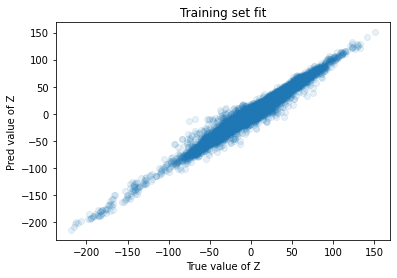

In [155]:
plt.scatter(mu.detach().numpy().flatten(), Z.flatten(), alpha=0.1)
plt.plot([-60, 100], [-60, 100])

plt.xlabel('True value of Z')
plt.ylabel("Pred value of Z")
plt.title("Training set fit")

Text(0.5, 1.0, 'Individual examples on training set')

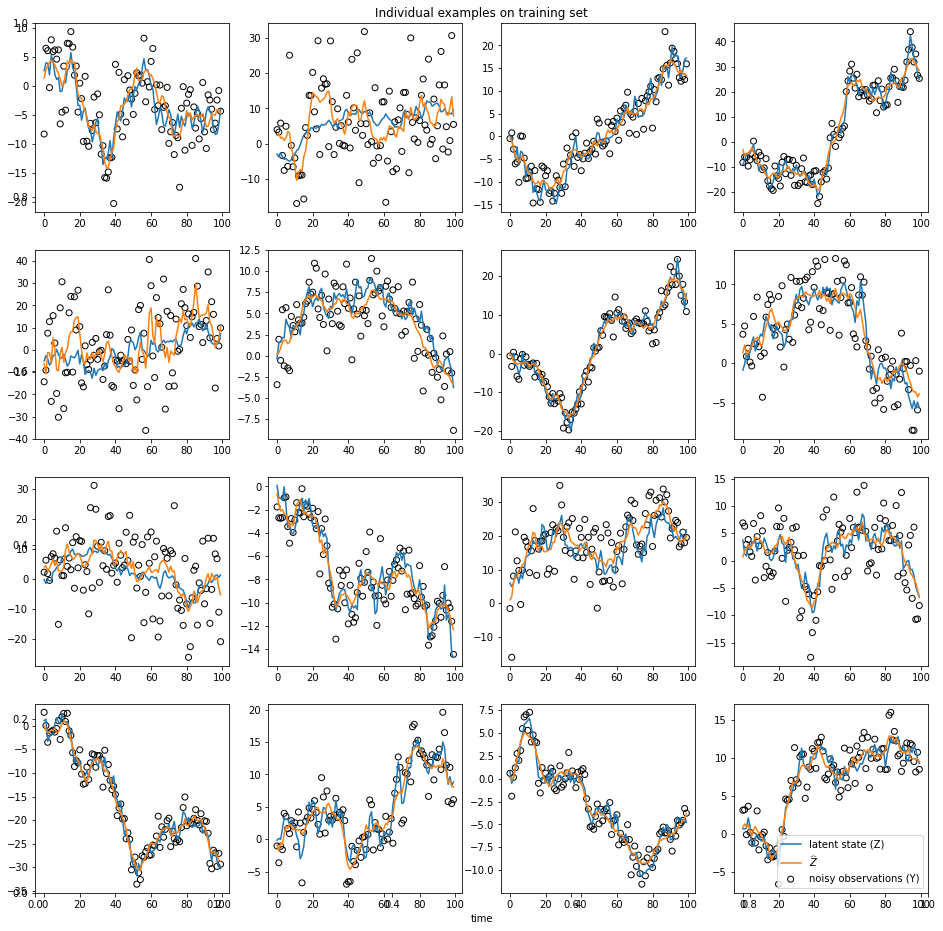

In [156]:
f, axes = plt.subplots(4, 4)
f.set_size_inches(16, 16)
for i in range(16):
  ax = axes[i//4][i%4]
  ax.scatter(
      np.arange(T),
      Y[i, :],
      label='noisy observations (Y)',
      color='k',
      facecolor='none'
  )
  ax.plot(Z[i, :], label='latent state (Z)')
  ax.plot(mu.detach().numpy()[i, :], label=r'$\widehat{Z}$')

ax.legend()
f.add_subplot(111, frameon=False)
plt.xlabel('time')
plt.title('Individual examples on training set')


Text(0.5, 1.0, 'Test set fit')

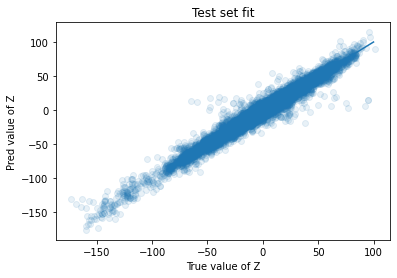

In [159]:
# Compare to holdout data estimates

Z_holdout, Y_holdout, _, _ = simulate_data()

with torch.no_grad():
  mu_holdout, sigma_holdout = v.encoder(Y_holdout)

plt.scatter(mu_holdout.detach().numpy().flatten(), Z_holdout.flatten(), alpha=0.1)
plt.plot([-60, 100], [-60, 100])

plt.xlabel('True value of Z')
plt.ylabel("Pred value of Z")
plt.title("Test set fit")

Text(0.5, 1.0, 'Individual examples on holdout set')

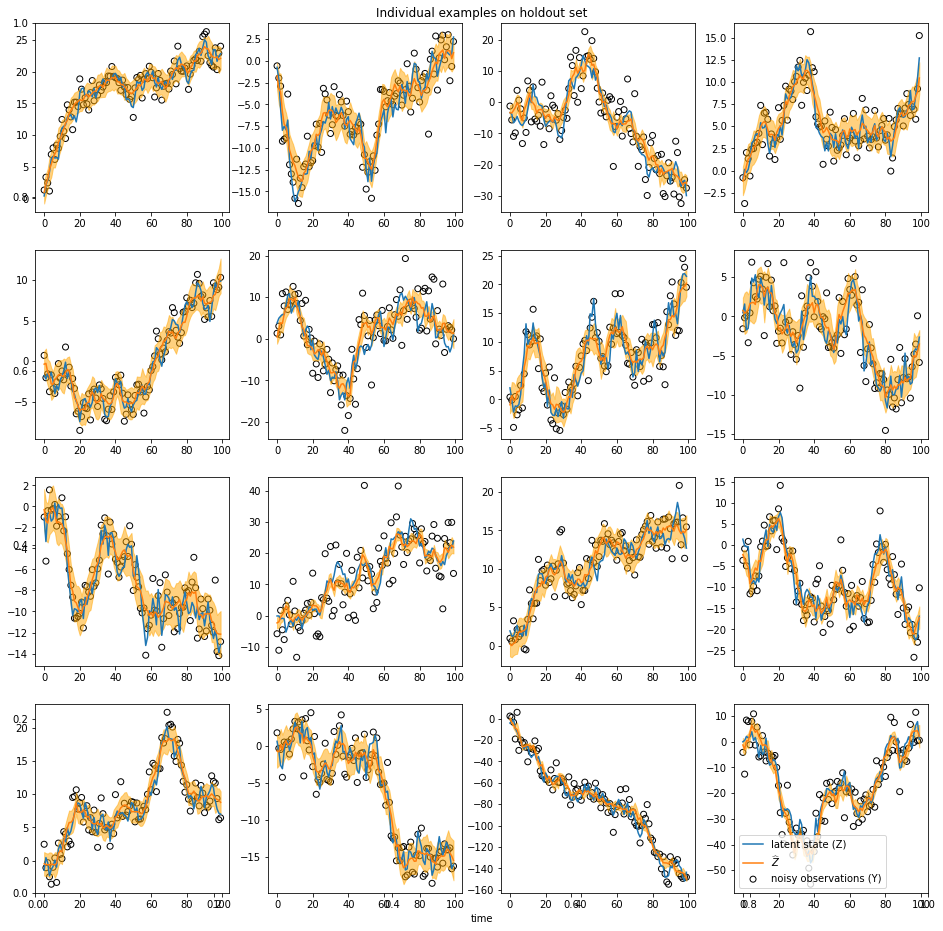

In [163]:
f, axes = plt.subplots(4, 4)
f.set_size_inches(16, 16)
for i in range(16):
  ax = axes[i//4][i%4]
  ax.scatter(
      np.arange(T),
      Y_holdout[i, :],
      label='noisy observations (Y)',
      color='k',
      facecolor='none'
  )
  ax.plot(Z_holdout[i, :], label='latent state (Z)')
  ax.plot(mu_holdout.detach().numpy()[i, :], label=r'$\widehat{Z}$')
  ax.fill_between(
      np.arange(T),
      mu_holdout.detach().numpy()[i, :] - 2*sigma_holdout.detach().numpy()[i, :],
      mu_holdout.detach().numpy()[i, :] + 2*sigma_holdout.detach().numpy()[i, :],
      color='orange', alpha=0.5
  )
ax.legend()
f.add_subplot(111, frameon=False)
plt.xlabel('time')
plt.title('Individual examples on holdout set')
